In [33]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from utils.folder import ImageFolder
from utils.common_utils import *
import visdom
import numpy as np

vis = visdom.Visdom()

plt.ion()   # interactive mode

## to start visdom server
sudo /home/yuan/anaconda3/bin/python -m visdom.server


In [34]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(400),
        transforms.CenterCrop(224),
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5, 0.75], [0.5, 0.5, 0.5,0.25])
    ]),
    'val': transforms.Compose([
#         transforms.Grayscale(num_output_channels=3),
#         transforms.Resize(400),
#         transforms.RandomResizedCrop(224),
        transforms.Resize(400),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5, 0.75], [0.5, 0.5, 0.5,0.25])
    ]),
}

data_dir = 'data'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [35]:
use_gpu

False

In [36]:
dataset_sizes

{'train': 8, 'val': 1}

In [37]:
# def pil_loader(path):
#     # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
#     with open(path, 'rb') as f:
#         img = Image.open(f)
#         return img.convert('RGB')

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



_inputs.shape= torch.Size([4, 4, 224, 224])
inputs min 0.0
inputs max 0.9764706
alphas min 0.003921628
alphas max 1.0
inputs mean 0.76077276 0.68341845 0.60615647 0.04042013
inputs std 0.25628388 0.20690691 0.20448363 0.18396781


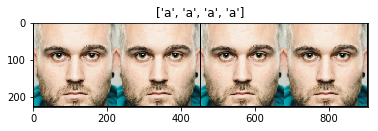

In [38]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
_inputs, classes = next(iter(dataloaders['train']))
print("_inputs.shape=",_inputs.shape)
# Make a grid from batch

inputs = _inputs[:,0:3,:,:]  # [-1,1]
inputs = inputs*0.5+0.5 #不需要clip  #[0,1]
print("inputs min",np.min(inputs.numpy()))
print("inputs max",np.max(inputs.numpy()))

alphas = _inputs[:,3:4,:,:] #[-1,1]
alphas = alphas*0.5+0.5 #不需要clip  #[0,1]
print("alphas min",np.min(alphas.numpy()))
print("alphas max",np.max(alphas.numpy()))

meanr = torch.mean(torch.FloatTensor(inputs[:,0,:,:])).numpy()
meang = torch.mean(torch.FloatTensor(inputs[:,1,:,:])).numpy()
meanb = torch.mean(torch.FloatTensor(inputs[:,2,:,:])).numpy()
meana = torch.mean(torch.FloatTensor(alphas[:,0,:,:])).numpy()

stdr = torch.std(torch.FloatTensor(inputs[:,0,:,:])).numpy()
stdg = torch.std(torch.FloatTensor(inputs[:,1,:,:])).numpy()
stdb = torch.std(torch.FloatTensor(inputs[:,2,:,:])).numpy()
stda = torch.std(torch.FloatTensor(alphas[:,0,:,:])).numpy()

print('inputs mean',meanr,meang,meanb,meana)
print('inputs std',stdr,stdg,stdb,stda)

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# img = np_to_pil(alphas[0].numpy())
# img.show() #显示方法之一
# img.save('bb.png')



In [39]:
# vis.image(out,win='in')

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [40]:
def plotLosses():
    plt.plot(all_losses['train'],label='train')
    plt.plot(all_losses['val'],label='val')
    plt.legend()


In [41]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0
    all_losses={'train':[],'val':[]}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            
            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs ,labels没有用，只是必须有这层结构
                _inputs, labels = data
                #把alpha通道拆出来，作为label,剩下的作为rgb3通道input
#                 print('_inputs.shape=',_inputs.shape)
                inputs = _inputs[:,0:3,:,:]
                labels = _inputs[:,3:4,:,:]
#                 labels = (labels-0.5)*2
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
#                 optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                #print('outputs mean =',torch.mean(outputs),torch.min(outputs),torch.max(outputs))
                #print('========= outputs===================',outputs[0])
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data.item() * inputs.size(0)
                #show sample
                RGBAShow(inputs.cpu().detach().numpy()[0], a_np1= labels.cpu().detach().numpy()[0], a_np2 = outputs.cpu().detach().numpy()[0],phase = phase)

            epoch_loss = running_loss / dataset_sizes[phase]
            all_losses[phase].append(epoch_loss)
            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'train' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())


            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,all_losses

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [42]:
from models.skip import skip
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'
reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01
OPTIMIZER='adam' # 'LBFGS'
show_every = 500
num_iter=2400
input_depth = 3
figsize = 5 
dtype = (torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)

net = skip(
            input_depth, num_output_channels=1, 
            num_channels_down = [8, 16, 32, 64, 128, 256, 512],
            num_channels_up   = [8, 16, 32, 64, 128, 256, 512],
            num_channels_skip = [0,  0,  0,  0,   0,   4,   4], 
            upsample_mode='bilinear',
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

net = net.type(dtype)
# print(net)

In [43]:
# for param in net.parameters():
#     print(type(param.data), param.size())
#     print(param.data)

# s = sum([np.prod(list(p.size())) for p in net.parameters() ])
# print(s)

In [44]:
# weights initializing is far important than you imaging
# learn from inpainting
for n in [x for x in net.parameters()]:
    n.data.normal_()

In [45]:
model_ft = net

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.MSELoss().type(dtype)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.005, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [46]:
def denomalize(nparray):
    return nparray*0.5+0.5

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [47]:
def RGBAShow(rgb_np,a_np1=None,a_np2=None,phase = ''):
    if phase == 'val':return
    vis.image(denomalize(rgb_np),win = 100,opts=dict(title=phase+'_rgb'))
    #     np_to_pil(rgb_np).show()
    if a_np1 is not None:
        vis.image(denomalize(a_np1),win = 110,opts=dict(title=phase+'_a1'))
        rgba1=np.concatenate((denomalize(rgb_np),denomalize(a_np1)),axis=0)
        vis.image(rgba1,win=111,opts=dict(title=phase+'_rgba1'))
    if a_np2 is not None:
        vis.image(denomalize(a_np2),win = 120,opts=dict(title=phase+'_a2_mask'))
        #rgba2=np.concatenate((denomalize(rgb_np),denomalize(a_np2)),axis=0)
        #vis.image(rgba2,win=121,opts=dict(title=phase+'_rgba2'))

        

In [ ]:
model_ft,all_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=220)

Epoch 0/219
----------


/Users/roger/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


train Loss: 0.9881
val Loss: 0.9795
Epoch 1/219
----------
train Loss: 0.9878
val Loss: 0.9795
Epoch 2/219
----------
train Loss: 0.9870
val Loss: 0.9795
Epoch 3/219
----------
train Loss: 0.9869
val Loss: 0.9795
Epoch 4/219
----------
train Loss: 0.9867
val Loss: 0.9795
Epoch 5/219
----------
train Loss: 0.9868
val Loss: 0.9796
Epoch 6/219
----------
train Loss: 0.9854
val Loss: 0.9834
Epoch 7/219
----------
train Loss: 0.9852
val Loss: 0.9835
Epoch 8/219
----------
train Loss: 0.9851
val Loss: 0.9860
Epoch 9/219
----------
train Loss: 0.9856
val Loss: 0.9858
Epoch 10/219
----------
train Loss: 0.9862
val Loss: 0.9851
Epoch 11/219
----------
train Loss: 0.9859
val Loss: 0.9838
Epoch 12/219
----------
train Loss: 0.9852
val Loss: 0.9856
Epoch 13/219
----------
train Loss: 0.9844
val Loss: 0.9860
Epoch 14/219
----------
train Loss: 0.9842
val Loss: 0.9857
Epoch 15/219
----------
train Loss: 0.9850
val Loss: 0.9866
Epoch 16/219
----------
train Loss: 0.9841
val Loss: 0.9864
Epoch 17/219


In [ ]:
plotLosses()

In [ ]:
# Show a picture 

# Get a batch of training data
_inputs, classes = next(iter(dataloaders['train']))
print("_inputs.shape=",_inputs.shape)
# Make a grid from batch
inputs = _inputs[:,0:3,:,:]

# print(inputs[0])
inputs_a = _inputs[:,3:4,:,:]
if use_gpu:
    inputs = Variable(inputs.cuda())

model_ft.train(False)    
outs = model_ft(inputs)


In [ ]:
rgb_batch = inputs.cpu().detach().numpy()
np_to_pil(rgb_batch[0]).save('rgb.jpg')

a2_batch = outs.cpu().detach().numpy()
a1_batch = inputs_a.cpu().detach().numpy()
rgba_batch = np.concatenate((rgb_batch,a2_batch),axis=1)

rgba_np=rgba_batch[1]
rgba_pil = np_to_pil(rgba_np)
rgba_pil.show()
rgba_pil.save('rgba.png')



In [47]:
RGBAShow(rgb_batch[0],a_np1=a1_batch[0],a_np2=a2_batch[0])


In [48]:
# def RGBAShowBatch(rgb_np,a_np):
#     out_np = np.concatenate((rgb_np,a_np),axis=1)
#     vis.images(out_np,win='out',opts=dict(caption='out list'),)

# RGBAShowBatch(rgb_batch,a_batch)

In [49]:
np.min(a2_batch)

0.0

In [50]:
np_to_pil(inputs.cpu().detach().numpy()[0]).save('input.jpg')

In [52]:
np_to_pil(ii[0:3,:,:]).save('_input.png')

In [ ]:
model_ft